**Examining the effect of number of layer - Arhitecture with 2 Layers**

In this notebook, the encoder and decoder, both with 2 layers, are created to examine the effect of number of layers, while the latent space dimension is fixed to 16.

In [1]:
# Import the modules necessary
import time 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import PIL.Image
import keras.backend as K
import glob, os
import random
from PIL import Image as Im

2023-08-13 02:05:12.492331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Load data from the pickle (array containing the images that are used in 4 layers architecture)

In [2]:
# Use the sample_pics pickle to use the same pictures for each architecture
import pickle

with open('sample_pics.pkl', 'rb') as f:
    sample_pics = pickle.load(f)

In [3]:
# Create a tensorflow dataset 
batch_size = 64 # pictures will be batched by size of 64 (except the last batch)
# Each element in the array corresponds to one element using from_tensor_slices
dataset = tf.data.Dataset.from_tensor_slices(sample_pics).batch(batch_size).shuffle(132) 
# Shuffle function providing a diverse and randomized order of elements 

2023-08-13 02:05:21.417277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**2. Build the Autoencoder**

In [4]:
# Firstly, create the Encoder whose output is mean and log-variance

# Define the size of latent space dimension
latent_space_dimension = 16

# Start with the Input layer (encoder_inputs) whose size is image_shape (64,64,3) 
encoder_inputs = layers.Input(shape = (64,64,3))

# Applying some filters, pooling etc. 
x = layers.Conv2D(filters = 16, kernel_size = (2,2), activation = 'relu', padding = 'same')(encoder_inputs) # Input is encoder_inputs
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 32, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Flatten()(x) # Flattening the network to go from Conv2D to 1D space

# Creating 2 Dense layers after flattening to represent mean and log-variance of the network created above
# Both of them connected to the same flattened layer
mean = layers.Dense(latent_space_dimension)(x) 
log_var = layers.Dense(latent_space_dimension)(x)

In [5]:
# Creating a layer named as Sampling whose function is to get the mean and log variance from the encoder 
# and then creating a random noise epsilon, and finally return z (output of the sampling)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean , z_log_var = inputs;
        batch_size = tf.shape(z_mean)[0]
        dimension = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch_size, dimension))
        return z_mean + tf.exp(z_log_var * 0.5) * epsilon

In [6]:
# Connecting the Encoder with Sampling Layer
output_sampling = Sampling()([mean, log_var])
encoder = tf.keras.Model(encoder_inputs, [mean,log_var,output_sampling],name = "Encoder_Architecture")
encoder.summary()

Model: "Encoder_Architecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                               

In [8]:
# Create the decoder (the input shape to the decoder is the shape of latent space)
decoder_inputs = layers.Input(shape = (latent_space_dimension,))

# Very Similar decoder architecture is used as the Practice 9 here... 
# The difference is that we should have an output size 64 x 64 x 3
# I.e., At the end 1 more UpSampling2D && filters = 3... 
x = layers.Dense(8*8*8, activation = 'relu')(decoder_inputs)
x = layers.Reshape((8,8,8))(x)
x = layers.Conv2D(filters = 32, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x) 
x = layers.UpSampling2D()(x) 
x = layers.Conv2D(filters = 16, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x) 
x = layers.Conv2D(filters = 3, kernel_size = (2,2), padding = 'same')(x) # 3 channels
decoder = tf.keras.Model(decoder_inputs, x, name = "Decoder_Architecture") 
decoder.summary()

Model: "Decoder_Architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_3 (Dense)             (None, 512)               8704      
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 8)           0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          1056      
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 32)         128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 32)          0         
                                              

In [9]:
# Combine the whole architecture encoder & decoder 
inp = encoder.input
out = encoder.output
decoder_output = decoder(out[2])
vae = tf.keras.Model(inp, decoder_output,name="4LayersArchitecture")
vae.summary()

Model: "4LayersArchitecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                                

**3. Define the Loss Function**

In [10]:
# define loss functions
def kl_loss(z_log_var,z_mean):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return kl_loss * 0.012

loss = tf.keras.losses.BinaryCrossentropy()
def reconstruction_loss(data,reconstructed):
    return loss(data,reconstructed)

optimizer = tf.keras.optimizers.Adam()  

In [11]:
# Train model using GRADIENT TAPE
def train_steps(data):
    total_loss = 0
    with tf.GradientTape() as vae_tape:
        z_mean,z_log_var,z = encoder(data)
        reconstructed_image = decoder(z)
        kl_ = kl_loss(z_log_var,z_mean)
        reconstruction_ = reconstruction_loss(data, reconstructed_image)
        total_loss = kl_ + reconstruction_

    gradient2 = vae_tape.gradient(total_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradient2, vae.trainable_variables))
    return total_loss

In [12]:
%matplotlib inline
# visualize results from epoch 
noise = tf.keras.backend.random_normal(shape = (9,latent_space_dimension))
def visualize(epoch):
        prediction = decoder(noise)
        plt.figure(figsize = (5,5))
        for i in range(9):
            if(i == 2):
                plt.title("Epoch: {}".format(epoch))
            plt.subplot(3,3,i+1)
            plt.imshow(prediction[i],cmap = 'gray')
            plt.axis('off')
            # Save the plot to the generated folder
            file_path = os.path.join('generated', 'generated_plot_epoch_{}.png'.format(epoch))
            plt.savefig(file_path)

In [13]:
# create training function
def train(dataset,epochs,start_epoch=0):

    loss_history = [] # To store loss values for each epoch

    for epoch in range(epochs):
        start = time.time()
        epoch_losses = []  # To store loss values for each batch in the epoch

        for batch in dataset:
            total_loss = train_steps(batch)
            # Append the mean of total_loss for each batch
            epoch_losses.append(np.sum(total_loss)/(total_loss.shape[0] * total_loss.shape[1]))
        
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses) # Calculate the average loss for the epoch
        loss_history.append(avg_epoch_loss)  # Store the average loss in the loss_history list

        print("Epoch: {} Time: {} Avg Loss: {}".format(epoch+1, np.round(time.time()-start, 2), avg_epoch_loss))

        if epoch % 10 == 0:
            visualize(epoch+1+start_epoch)
        
    return loss_history  # Return the list of average epoch losses



Epoch: 1 Time: 3.99 Avg Loss: 1.2601994432508945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 Time: 3.72 Avg Loss: 0.7552151173353195
Epoch: 3 Time: 3.75 Avg Loss: 0.7312143042683601
Epoch: 4 Time: 3.75 Avg Loss: 0.7204888693988323
Epoch: 5 Time: 3.74 Avg Loss: 0.7156065091490745
Epoch: 6 Time: 3.73 Avg Loss: 0.712781124562025
Epoch: 7 Time: 3.95 Avg Loss: 0.7101470075547696
Epoch: 8 Time: 4.02 Avg Loss: 0.7080491103231907
Epoch: 9 Time: 3.99 Avg Loss: 0.7058260433375836
Epoch: 10 Time: 3.84 Avg Loss: 0.7044136911630631
Epoch: 11 Time: 3.94 Avg Loss: 0.7029776364564896


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 12 Time: 3.92 Avg Loss: 0.7011309176683426
Epoch: 13 Time: 3.8 Avg Loss: 0.7001292668282986
Epoch: 14 Time: 3.8 Avg Loss: 0.6991116315126419
Epoch: 15 Time: 3.79 Avg Loss: 0.6979017026722432
Epoch: 16 Time: 3.84 Avg Loss: 0.6971804983913898
Epoch: 17 Time: 3.84 Avg Loss: 0.6961441703140736
Epoch: 18 Time: 3.79 Avg Loss: 0.695108762383461
Epoch: 19 Time: 3.83 Avg Loss: 0.6940753117203713
Epoch: 20 Time: 3.84 Avg Loss: 0.6931460909545422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 21 Time: 3.83 Avg Loss: 0.6923301987349987


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 22 Time: 3.91 Avg Loss: 0.6913012802600861
Epoch: 23 Time: 3.78 Avg Loss: 0.6905378825962544
Epoch: 24 Time: 3.81 Avg Loss: 0.6898342527449131
Epoch: 25 Time: 3.81 Avg Loss: 0.6885015964508057
Epoch: 26 Time: 3.82 Avg Loss: 0.6878519132733345
Epoch: 27 Time: 3.85 Avg Loss: 0.6861284963786602
Epoch: 28 Time: 3.81 Avg Loss: 0.6849463872611523
Epoch: 29 Time: 3.78 Avg Loss: 0.6835087537765503
Epoch: 30 Time: 3.82 Avg Loss: 0.68096464574337


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 31 Time: 3.87 Avg Loss: 0.678460780531168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 32 Time: 3.77 Avg Loss: 0.6813675835728645
Epoch: 33 Time: 3.8 Avg Loss: 0.679593063890934
Epoch: 34 Time: 3.81 Avg Loss: 0.6712050460278988
Epoch: 35 Time: 3.8 Avg Loss: 0.6666868194937706
Epoch: 36 Time: 3.75 Avg Loss: 0.6624764621257782
Epoch: 37 Time: 3.82 Avg Loss: 0.6589970625936985
Epoch: 38 Time: 3.78 Avg Loss: 0.6558277398347855
Epoch: 39 Time: 3.81 Avg Loss: 0.6574437849223613
Epoch: 40 Time: 3.8 Avg Loss: 0.6582847207784652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 41 Time: 3.79 Avg Loss: 0.6515399485826492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 42 Time: 3.86 Avg Loss: 0.6483009435236454
Epoch: 43 Time: 3.83 Avg Loss: 0.6460649073123932
Epoch: 44 Time: 3.86 Avg Loss: 0.6443815909326076
Epoch: 45 Time: 3.88 Avg Loss: 0.6434660091996193
Epoch: 46 Time: 3.8 Avg Loss: 0.6430827558040619
Epoch: 47 Time: 3.84 Avg Loss: 0.6412937477231025
Epoch: 48 Time: 3.82 Avg Loss: 0.6392643496394157
Epoch: 49 Time: 3.75 Avg Loss: 0.6385343693196773
Epoch: 50 Time: 3.83 Avg Loss: 0.6375912882387638


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 51 Time: 3.8 Avg Loss: 0.6368684567511081


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 52 Time: 3.88 Avg Loss: 0.635806804150343
Epoch: 53 Time: 3.82 Avg Loss: 0.6365279041230678
Epoch: 54 Time: 3.78 Avg Loss: 0.6347485788166523
Epoch: 55 Time: 3.81 Avg Loss: 0.6337195679545402
Epoch: 56 Time: 3.85 Avg Loss: 0.6326851092278958
Epoch: 57 Time: 3.83 Avg Loss: 0.6321562081575394
Epoch: 58 Time: 3.77 Avg Loss: 0.6309372790157795
Epoch: 59 Time: 3.85 Avg Loss: 0.630377546697855
Epoch: 60 Time: 3.83 Avg Loss: 0.6303280927240849


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 61 Time: 3.82 Avg Loss: 0.6297040112316609


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 62 Time: 3.81 Avg Loss: 0.6302538365125656
Epoch: 63 Time: 3.76 Avg Loss: 0.6288757525384426
Epoch: 64 Time: 3.82 Avg Loss: 0.627142671495676
Epoch: 65 Time: 3.83 Avg Loss: 0.6264598123729229
Epoch: 66 Time: 3.8 Avg Loss: 0.6255456566810608
Epoch: 67 Time: 3.76 Avg Loss: 0.6253289923071861
Epoch: 68 Time: 3.8 Avg Loss: 0.6254455275833607
Epoch: 69 Time: 3.83 Avg Loss: 0.6249596558511257
Epoch: 70 Time: 3.83 Avg Loss: 0.634951513260603


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 71 Time: 3.78 Avg Loss: 0.6282272584736347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 72 Time: 3.87 Avg Loss: 0.6255667984485627
Epoch: 73 Time: 3.82 Avg Loss: 0.6243845075368881
Epoch: 74 Time: 3.83 Avg Loss: 0.6233289629220963
Epoch: 75 Time: 3.82 Avg Loss: 0.6225193999707699
Epoch: 76 Time: 3.81 Avg Loss: 0.6223164461553097
Epoch: 77 Time: 3.78 Avg Loss: 0.6226054914295673
Epoch: 78 Time: 3.85 Avg Loss: 0.6275071121752263
Epoch: 79 Time: 3.83 Avg Loss: 0.6234400115907193
Epoch: 80 Time: 3.82 Avg Loss: 0.6219594575464725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 81 Time: 3.77 Avg Loss: 0.6212724357843399


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 82 Time: 3.84 Avg Loss: 0.6208550356328487
Epoch: 83 Time: 3.82 Avg Loss: 0.6204756073653698
Epoch: 84 Time: 3.8 Avg Loss: 0.6201664417982101
Epoch: 85 Time: 3.79 Avg Loss: 0.6198781199753285
Epoch: 86 Time: 3.8 Avg Loss: 0.619864608347416
Epoch: 87 Time: 3.83 Avg Loss: 0.6199811868369579
Epoch: 88 Time: 3.8 Avg Loss: 0.6194132849574089
Epoch: 89 Time: 3.88 Avg Loss: 0.6192587025463581
Epoch: 90 Time: 3.86 Avg Loss: 0.6193407349288463


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 91 Time: 3.93 Avg Loss: 0.6186290942132473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 92 Time: 4.0 Avg Loss: 0.6184248588979244
Epoch: 93 Time: 3.97 Avg Loss: 0.6183567449450493
Epoch: 94 Time: 3.93 Avg Loss: 0.6182756699621678
Epoch: 95 Time: 3.89 Avg Loss: 0.6180474780499935
Epoch: 96 Time: 3.96 Avg Loss: 0.6187006451189518
Epoch: 97 Time: 4.04 Avg Loss: 0.6218006461858749
Epoch: 98 Time: 4.08 Avg Loss: 0.6193727947771549
Epoch: 99 Time: 4.07 Avg Loss: 0.6183351926505566
Epoch: 100 Time: 4.11 Avg Loss: 0.6175895147025585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 101 Time: 4.25 Avg Loss: 0.6174198545515537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 102 Time: 4.05 Avg Loss: 0.6169987805187702
Epoch: 103 Time: 4.15 Avg Loss: 0.617347127199173
Epoch: 104 Time: 4.13 Avg Loss: 0.6170768097043038
Epoch: 105 Time: 3.82 Avg Loss: 0.6167017765343189
Epoch: 106 Time: 3.8 Avg Loss: 0.6165272302925586
Epoch: 107 Time: 3.84 Avg Loss: 0.6162827789783478
Epoch: 108 Time: 3.84 Avg Loss: 0.6162977375090122
Epoch: 109 Time: 3.81 Avg Loss: 0.6207951426506042
Epoch: 110 Time: 3.77 Avg Loss: 0.6582702234387398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 111 Time: 3.82 Avg Loss: 0.6346255220472813


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 112 Time: 3.87 Avg Loss: 0.6249105401337147
Epoch: 113 Time: 3.85 Avg Loss: 0.6208872601389885
Epoch: 114 Time: 3.79 Avg Loss: 0.6191732160747051
Epoch: 115 Time: 3.82 Avg Loss: 0.618478362262249
Epoch: 116 Time: 3.85 Avg Loss: 0.6197930976748467
Epoch: 117 Time: 3.85 Avg Loss: 0.6251865945756435
Epoch: 118 Time: 3.84 Avg Loss: 0.621498815715313
Epoch: 119 Time: 3.8 Avg Loss: 0.6187560722231865
Epoch: 120 Time: 3.83 Avg Loss: 0.6174460262060165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 121 Time: 3.87 Avg Loss: 0.6176638908684253


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 122 Time: 3.87 Avg Loss: 0.6171971380710601
Epoch: 123 Time: 3.84 Avg Loss: 0.6168090753257275
Epoch: 124 Time: 3.86 Avg Loss: 0.6171103499829769
Epoch: 125 Time: 3.82 Avg Loss: 0.6164469078183175
Epoch: 126 Time: 3.87 Avg Loss: 0.6158704333007335
Epoch: 127 Time: 3.84 Avg Loss: 0.6155421704053878
Epoch: 128 Time: 3.79 Avg Loss: 0.6158657111227512
Epoch: 129 Time: 3.84 Avg Loss: 0.6152781888842582
Epoch: 130 Time: 3.84 Avg Loss: 0.6153748482465744


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 131 Time: 3.86 Avg Loss: 0.6153912708163262


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 132 Time: 4.02 Avg Loss: 0.6149956867098808
Epoch: 133 Time: 4.11 Avg Loss: 0.6147231817245483
Epoch: 134 Time: 3.81 Avg Loss: 0.6143918827176094
Epoch: 135 Time: 3.83 Avg Loss: 0.6142719000577926
Epoch: 136 Time: 3.84 Avg Loss: 0.6142990201711654
Epoch: 137 Time: 3.79 Avg Loss: 0.61441243365407
Epoch: 138 Time: 3.81 Avg Loss: 0.6148283459246159
Epoch: 139 Time: 3.86 Avg Loss: 0.616779013723135
Epoch: 140 Time: 3.87 Avg Loss: 0.6150636970996857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 141 Time: 3.81 Avg Loss: 0.6145054243505002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 142 Time: 3.88 Avg Loss: 0.6138915151357651
Epoch: 143 Time: 3.81 Avg Loss: 0.6136285230517388
Epoch: 144 Time: 3.82 Avg Loss: 0.6137417800724506
Epoch: 145 Time: 4.11 Avg Loss: 0.6136242881417274
Epoch: 146 Time: 4.06 Avg Loss: 0.6131796345114708
Epoch: 147 Time: 4.06 Avg Loss: 0.6131385788321495
Epoch: 148 Time: 3.99 Avg Loss: 0.6130381986498833
Epoch: 149 Time: 4.02 Avg Loss: 0.6131323531270028
Epoch: 150 Time: 3.95 Avg Loss: 0.6131358601152896


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 151 Time: 4.15 Avg Loss: 0.6128720462322235


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


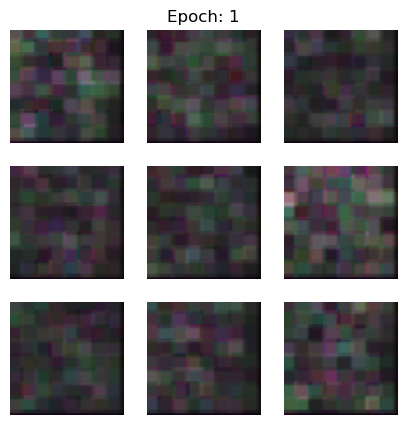

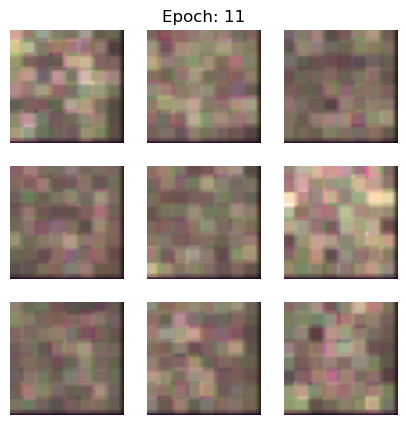

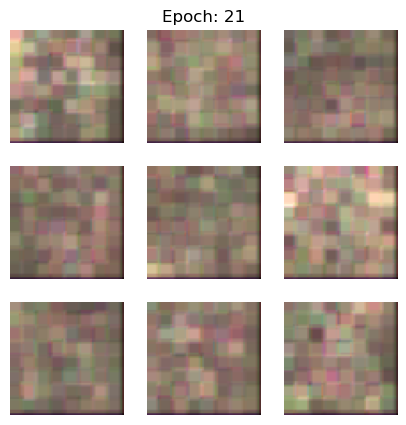

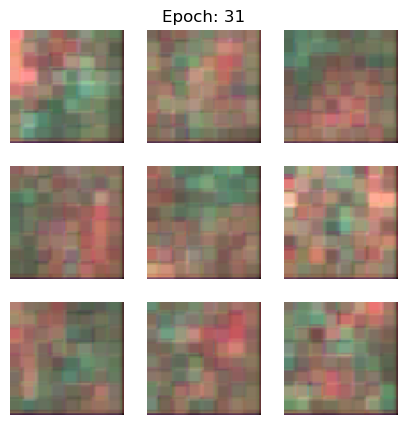

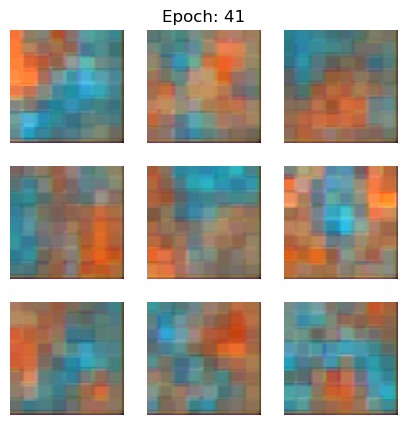

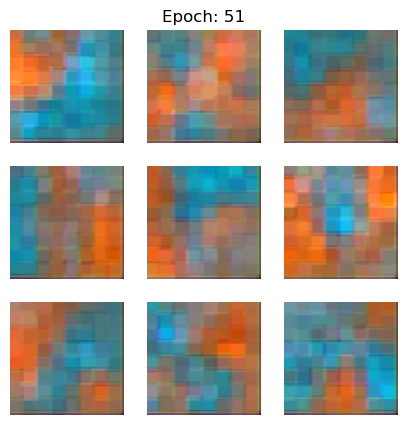

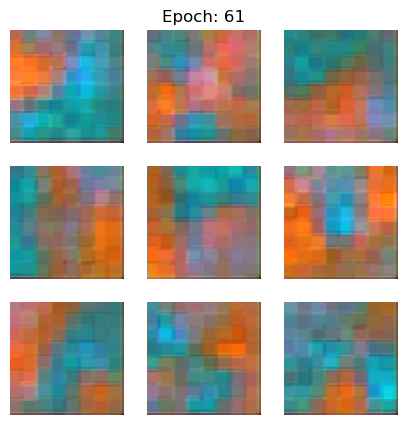

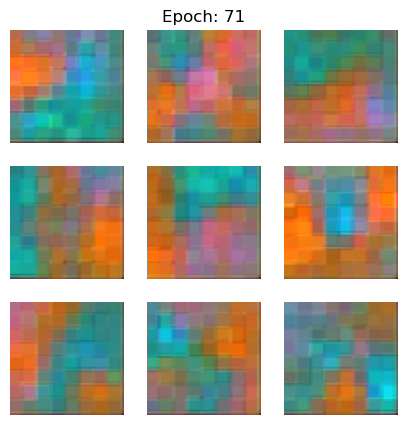

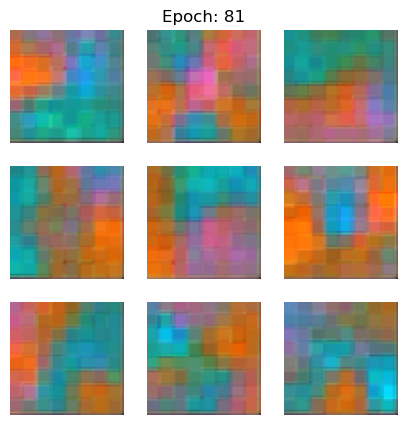

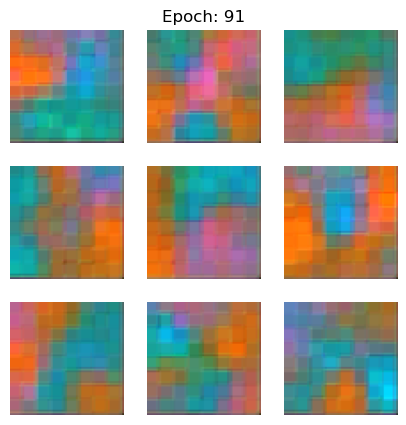

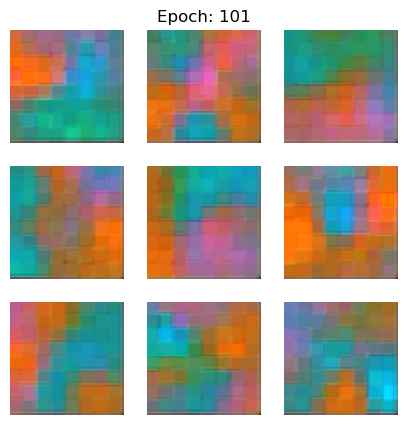

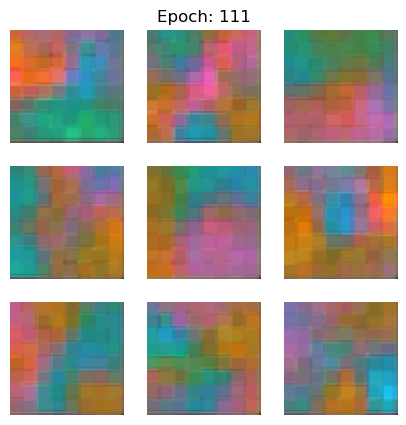

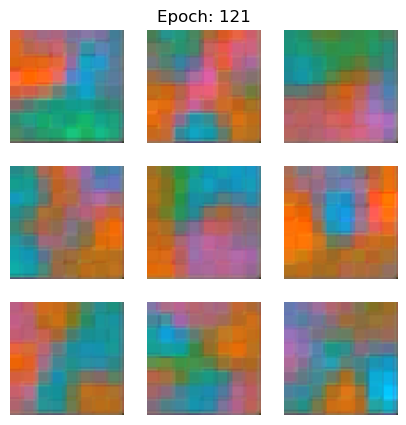

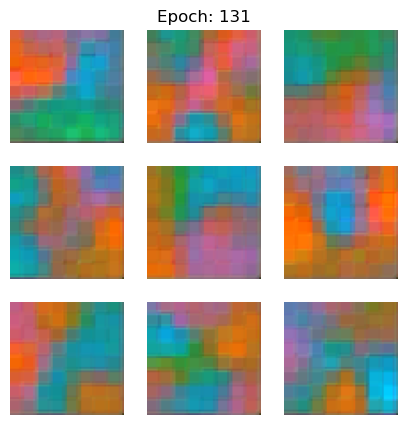

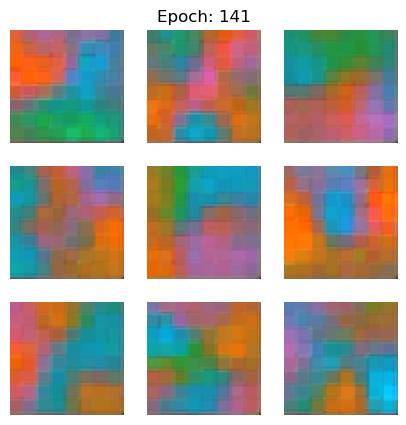

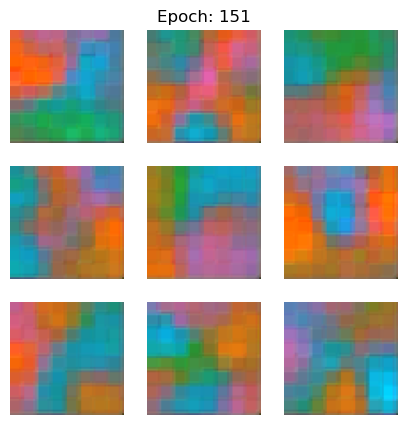

In [14]:
%matplotlib inline
# Train the data set
epochs = 151
architecture_loss_history = train(dataset,epochs=epochs,start_epoch=0)
# Save the weights
generated_weights_folder = os.path.join(os.getcwd(),'weights')
vae.save_weights(os.path.join(generated_weights_folder, f'weights_for_2_layers'))

In [15]:
# Saving architecture_loss_history to compare it with other architectures
with open('architecture_loss_history_2_layers.pkl', 'wb') as f:
    pickle.dump(architecture_loss_history, f)